In [1]:
import sys
sys.path.append('../')

In [2]:
from src.models import DefConvNet, DeformableFCN
from src.utils import load_data, to_torch_dataset, to_torch_loader

import warnings
warnings.filterwarnings('ignore')

from lightning.pytorch import seed_everything
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

import numpy as np
import pandas as pd
import time

In [3]:
# Ensure reproducibility
seed_everything(42, workers=True)

Seed set to 42


42

In [4]:
DATASETS = [
    'Beef',
]

MODELS_DIR = '../models/classification/univariate/'

NUMBER_OF_EXPERIMENTS = 1
NUMBER_OF_EPOCHS = 1000

for dataset in DATASETS:
    print(f'Loading dataset {dataset}...')
    X_train, y_train, X_test, y_test = load_data(name=dataset, task='classification', split='full')
    
    print('Converting the dataset to torch.DataLoader...')
    train_set, test_set = to_torch_dataset(X_train, y_train, X_test, y_test)
    train_loader, test_loader = to_torch_loader(train_dataset=train_set, test_dataset=test_set)

    num_classes = len(np.unique(y_train))

    for experiment_number in range(NUMBER_OF_EXPERIMENTS):
        model = DefConvNet(in_dim=1, num_classes=num_classes)
        # print(model)
        checkpoint = ModelCheckpoint(
            monitor='train_loss',
            dirpath=f'{MODELS_DIR}',
            filename=f'deffcn-{dataset}-{experiment_number}',
            save_top_k=1,
            auto_insert_metric_name=False
        )
        
        logger = CSVLogger('../../../logs/classification', name=f'deformable_fcn_ucr_subset_{dataset}')

        trainer = Trainer(
            max_epochs=NUMBER_OF_EPOCHS,
            accelerator='gpu',
            callbacks=[checkpoint],
            logger=logger
        )

        start_time = time.time()
        trainer.fit(
            model,
            train_dataloaders=train_loader,
        )
        end_time = time.time()

        results = trainer.test(dataloaders=test_loader, ckpt_path='best')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading dataset Beef...
Converting the dataset to torch.DataLoader...


You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | conv_layers | Sequential       | 958 K 
1 | linear      | Linear           | 1.3 K 
2 | criteria    | CrossEntropyLoss | 0     
-------------------------------------------------
959 K     Trainable params
0         Non-trainable params
959 K     Total params
3.838     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
Restoring states from the checkpoint path at /home/gilberto/projects/defconv_time_series/models/classification/univariate/deffcn-Beef-0-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/gilberto/projects/defconv_time_series/models/classification/univariate/deffcn-Beef-0-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           acc              0.7333333492279053
           f1               0.5139394402503967
        precision           0.5922222137451172
         recall             0.46444445848464966
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


$$
y(p) = \sum^K_{k=1} w_k \cdot x(p_0 + p_{n_k} + \Delta p_{n_k}) \cdot \Delta m_k
$$

In [19]:
import pandas as pd
import numpy as np
metrics = pd.read_csv('./metrics.csv')

val_acc = metrics['val_acc'].dropna().values
val_loss = metrics['val_loss'].dropna().values

val_loss.shape, val_acc.shape

((55,), (55,))

In [20]:
train_acc = metrics['train_acc'].dropna().values
train_loss = metrics['train_loss'].dropna().values

train_acc.shape, train_loss.shape

((55,), (55,))

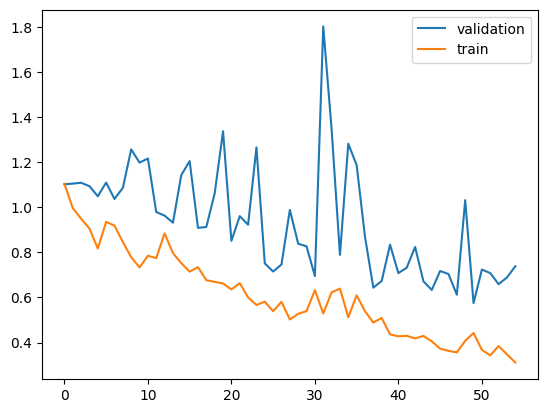

In [21]:
import matplotlib.pyplot as plt

plt.plot(list(range(val_loss.shape[0])), val_loss, label='validation')
plt.plot(list(range(val_loss.shape[0])), train_loss, label='train')
plt.legend()


In [13]:
np.argmin(train_loss[:]), np.argmin(val_loss[:])

(970, 249)

In [15]:
np.argmax(train_acc[:]), np.argmax(val_acc[:]), np.max(val_acc)

(120, 907, 0.9085714221000672)

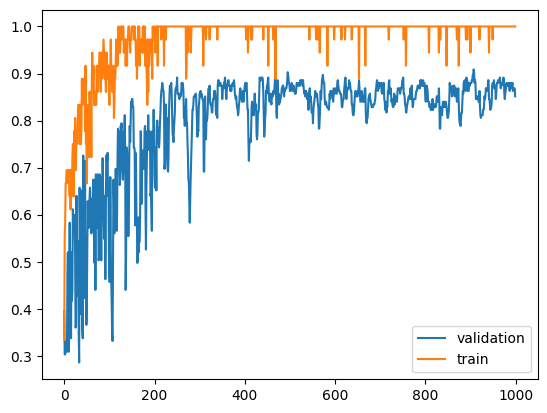

In [8]:
plt.plot(list(range(val_loss.shape[0])), val_acc, label='validation')
plt.plot(list(range(val_loss.shape[0])), train_acc, label='train')
plt.legend()

In [19]:
train_loss[-1], min(train_loss)

(0.0081645045429468, 0.0081645045429468)